<a href="https://colab.research.google.com/github/NegarMov/Linguistic-Signals-of-Mental-Health/blob/main/Linguistic_Signals_of_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Required Libraries

In [ ]:
import os
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

#Define Constants and Set the Seed

In [ ]:
TEST_SIZE = 0.05
VAL_SIZE = 0.05
SEED = 42
MAX_TOKENS = 256
FREEZE_LAYERS = 8
EPOCHS = 15
BATCH_SIZE = 16
LR = 2e-5

In [ ]:
random.seed(SEED)
torch.manual_seed(SEED)

#Download Dataset from Kaggle

In [ ]:
import kagglehub

path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

path

Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.


'/kaggle/input/sentiment-analysis-for-mental-health'

#Load, Analyze, and Clean the Dataset

Load the dataset from the CSV file into a pandas DataFrame

In [ ]:
data = pd.read_csv(os.path.join(path, 'Combined Data.csv'))

data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


Remove extra columns, rename columns for clarity, and drop missing values

In [ ]:
data.pop('Unnamed: 0')

data = data.rename(columns={'statement': 'text', 'status': 'label'})

data = data.dropna(subset=['text', 'label'])

data.head()

,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


Plot the class distribution to understand the dataset balance

In [ ]:
num_classes = len(data['label'].unique())

num_classes

7

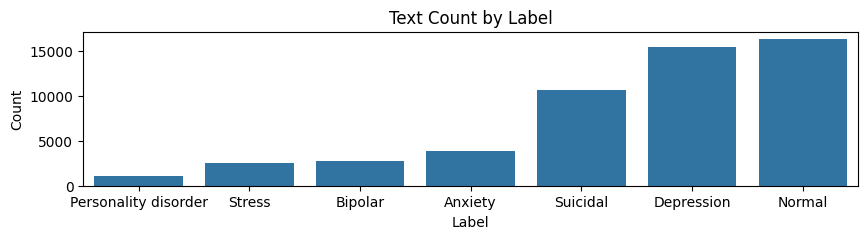

,count
label,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [ ]:
plt.figure(figsize=(10, 2))
sns.barplot(
    data=data.groupby('label')['text'].count().sort_values().reset_index(),
    x='label',
    y='text'
)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Text Count by Label')
plt.show()

data['label'].value_counts()

explore how text length and vocabulary size vary across mental health conditions

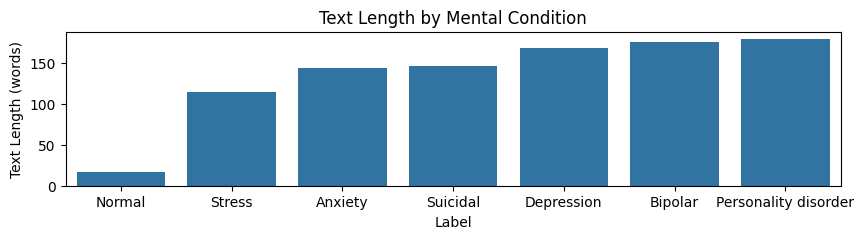

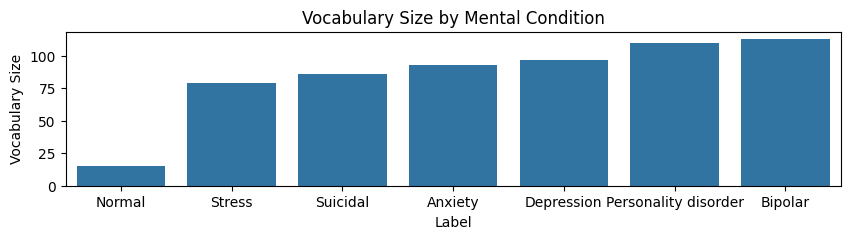

In [ ]:
data['num_words'] = data['text'].apply(lambda x: len(x.split()))
data['vocab_size'] = data['text'].apply(lambda x: len(set(x.split())))

plt.figure(figsize=(10, 2))
sns.barplot(
    data=data.groupby('label')['num_words'].mean().sort_values().reset_index(),
    x='label',
    y='num_words'
)
plt.xlabel('Label')
plt.ylabel('Text Length (words)')
plt.title('Text Length by Mental Condition')
plt.show()

plt.figure(figsize=(10, 2))
sns.barplot(
    data=data.groupby('label')['vocab_size'].mean().sort_values().reset_index(),
    x='label',
    y='vocab_size'
)
plt.xlabel('Label')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size by Mental Condition')
plt.show()

Generate a word cloud for each class

In [ ]:
def get_top_words(label, n=15):
    texts = data[data['label'] == label]['text']
    all_words = ' '.join(texts).split()
    common_words = Counter(all_words).most_common(n)
    return common_words

def plot_wordcloud(label):
    text = ' '.join(data[data['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(label)
    plt.tight_layout()
    plt.show()

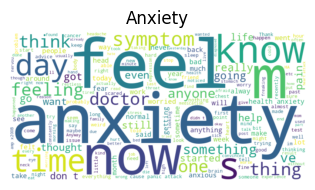

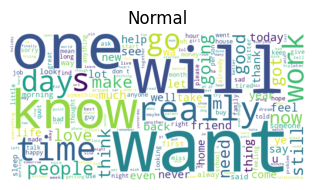

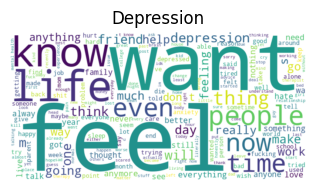

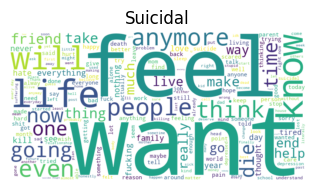

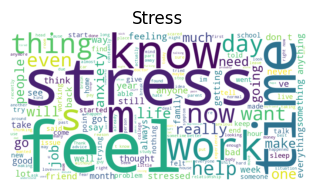

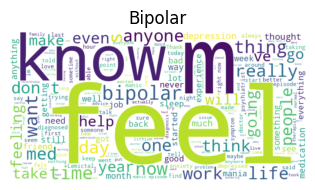

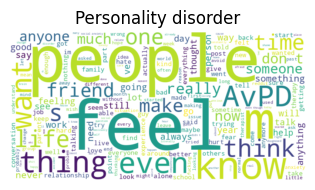

In [ ]:
for label in data['label'].unique():
    plot_wordcloud(label)

Encode the labels into numerical values

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])

data.head()

,text,label,num_words,vocab_size
0,oh my gosh,0,3,3
1,"trouble sleeping, confused mind, restless hear...",0,10,10
2,"All wrong, back off dear, forward doubt. Stay ...",0,14,13
3,I've shifted my focus to something else but I'...,0,11,11
4,"I'm restless and restless, it's been a month n...",0,14,14


##Train/Validation/Test Split

In [ ]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    data['text'].values,
    data['label'].values,
    test_size=TEST_SIZE,
    stratify=data['label'].values,
    random_state=SEED
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=VAL_SIZE,
    stratify=train_val_labels,
    random_state=SEED
)

len(train_texts), len(val_texts), len(test_texts)

(47543, 2503, 2635)

##Handle Class Imbalance

In [ ]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})

target_size = train_df['label'].value_counts().values[num_classes // 2]

target_size

np.int64(3467)

In [ ]:
def chunk_text(text, max_chunks=5):
    # split by paragraph or sentence
    chunks = [c.strip() for c in re.split(r'\n\n+|\n|(?<=\.) ', text) if c.strip()]
    if len(chunks) <= max_chunks:
        return chunks
    return random.sample(chunks, max_chunks)

def chunk_mix(text1, text2, max_chunks=5):
    c1 = chunk_text(text1, max_chunks)
    c2 = chunk_text(text2, max_chunks)
    mixed = c1[:len(c1)//2] + c2[len(c2)//2:]
    random.shuffle(mixed)
    return " ".join(mixed)

In [ ]:
def shuffle_sentences(text):
    sents = [s.strip() for s in re.split(r'\n|(?<=\.) ', text) if s.strip()]
    if len(sents) < 2:
        return text
    random.shuffle(sents)
    return " ".join(sents)

In [ ]:
def random_span_dropout(text, drop_prob=0.2):
    sents = [s.strip() for s in re.split(r'\n|(?<=\.) ', text) if s.strip()]
    if len(sents) <= 2:
        return text

    kept = [s for s in sents if random.random() > drop_prob]
    if len(kept) < 1:
        kept = random.sample(sents, 1)

    return " ".join(kept)

In [ ]:
def augment(text, peer_text=None):
    r = random.random()

    if r < 0.4:
        return shuffle_sentences(text)
    elif r < 0.7:
        return random_span_dropout(text)
    else:
        if peer_text is not None:
            return chunk_mix(text, peer_text)
        return shuffle_sentences(text)

In [ ]:
def get_tfidf_embeddings(texts):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    embeddings = vectorizer.fit_transform(texts)
    return embeddings.toarray(), vectorizer

In [ ]:
def downsample(df, target_size, label):
    if len(df) <= target_size:
        return df

    print(f"Downsampling label {label}: {len(df)} -> {target_size}")

    embeddings, _ = get_tfidf_embeddings(df['text'].tolist())

    # cluster the data for even sampling
    n_clusters = min(50, target_size // 40)
    kmeans = KMeans(n_clusters=n_clusters, random_state=SEED, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    sampled_indices = []
    for cluster in range(n_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        n_sample = min(len(cluster_indices), target_size // n_clusters + 1)
        sampled_indices.extend(np.random.choice(cluster_indices, n_sample, replace=False))

    return df.iloc[sampled_indices].reset_index(drop=False)

In [ ]:
class_counts = train_df['label'].value_counts()
print("Original distribution:")
print(class_counts)

balanced_dfs = []
for label in class_counts.index:
    label_df = train_df[train_df['label'] == label].reset_index(drop=True)
    current_size = len(label_df)

    if current_size > target_size:
        balanced_df = downsample(label_df, target_size, label)
    else:
        needed = target_size - current_size
        print(f"Upsampling label {label}: {current_size} -> {target_size}")

        balanced_df = label_df.copy()
        aug_samples = []

        indices = np.random.choice(current_size, needed, replace=True)

        for idx in indices:
            text = label_df.iloc[idx]['text']
            peer_idx = random.randint(0, current_size - 1)
            peer_text = label_df.iloc[peer_idx]['text']
            aug_text = augment(text, peer_text)
            aug_samples.append({'text': aug_text, 'label': label})

        aug_df = pd.DataFrame(aug_samples)
        balanced_df = pd.concat([balanced_df, aug_df], ignore_index=True)

    balanced_dfs.append(balanced_df)


train_df_balanced = pd.concat(balanced_dfs, ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

print("Balanced distribution:")
print(train_df_balanced['label'].value_counts().sort_index())

print(f"Total: {len(train_df)} -> {len(train_df_balanced)}")

Original distribution:
label
3    14749
2    13901
6     9613
0     3467
1     2506
5     2335
4      972
Name: count, dtype: int64
Downsampling label 3: 14749 -> 3467
Downsampling label 2: 13901 -> 3467
Downsampling label 6: 9613 -> 3467
Upsampling label 0: 3467 -> 3467
Upsampling label 1: 2506 -> 3467
Upsampling label 5: 2335 -> 3467
Upsampling label 4: 972 -> 3467
Balanced distribution:
label
0    3467
1    3467
2    3463
3    3079
4    3467
5    3467
6    3314
Name: count, dtype: int64
Total: 47543 -> 23724


##Build the Dataset

In [ ]:
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # tokenize
        tokens = self.tokenizer.tokenize(text)

        # if too long, just use the beginning + end of the text
        if len(tokens) > self.max_len - 2:
            half = (self.max_len - 2) // 2
            tokens = tokens[:half] + tokens[-half:]

        encoding = self.tokenizer.encode_plus(
            tokens,
            is_split_into_words=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Each text sample is tokenized on-the-fly when it gets retrieved from the dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = MentalHealthDataset(
  train_df_balanced['text'],
  train_df_balanced['label'],
  tokenizer,
  max_len=MAX_TOKENS
)
val_dataset = MentalHealthDataset(
  val_texts,
  val_labels,
  tokenizer,
  max_len=MAX_TOKENS
)
test_dataset = MentalHealthDataset(
  test_texts,
  test_labels,
  tokenizer,
  max_len=MAX_TOKENS
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

#Build the Classification Model
Bert (partially freezed) for sequence embedding + Linear for classification

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, hidden_size=768, num_classes=2, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # freeze all but the last layers
        for name, param in self.bert.named_parameters():
          match = re.search(r'encoder\.layer\.(\d+)', name)
          layer_number = int(match.group(1)) if match else None

          if layer_number is None:
            param.requires_grad = name.startswith("pooler")
          else:
            param.requires_grad = layer_number >= FREEZE_LAYERS

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_size, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_embedding)
        return logits

#Initialize and Train the Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Classifier(hidden_size=768, num_classes=num_classes, dropout=0.3).to(device)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

This section is for visualization only. This will help us analyze how the learned embeddings will improve class separation after training

In [ ]:
def get_embeddings(model, data_loader, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for i, batch in tqdm(enumerate(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model.bert(input_ids, attention_mask)
            cls_emb = outputs.last_hidden_state[:, 0, :]

            embeddings.append(cls_emb.cpu())
            labels.append(batch['labels'])

    return torch.cat(embeddings).numpy(), np.concatenate(labels)

In [ ]:
pre_emb, pre_labels = get_embeddings(model, test_loader, device)

165it [00:23,  6.97it/s]


One epoch of training

In [ ]:
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


One epoch of validation

In [ ]:
@torch.no_grad()
def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in tqdm(data_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


##Main Training Loop
At this step, the best model (based on validation accuracy) will be chosen and saved

In [ ]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

for epoch in range(EPOCHS):
    print("Training...")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    print("Validating...")
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'model.pth')

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}"
    )

model.load_state_dict(torch.load('model.pth'))

Training...


100%|██████████| 1483/1483 [04:39<00:00,  5.30it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


Epoch 1/15 | Train loss: 0.6799 acc: 0.6495 | Val loss: 0.6757 acc: 0.6904
Training...


100%|██████████| 1483/1483 [04:39<00:00,  5.30it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.05it/s]


Epoch 2/15 | Train loss: 0.3636 acc: 0.8043 | Val loss: 0.6485 acc: 0.7363
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 3/15 | Train loss: 0.2463 acc: 0.8476 | Val loss: 0.5997 acc: 0.7515
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


Epoch 4/15 | Train loss: 0.1739 acc: 0.8745 | Val loss: 0.5472 acc: 0.7671
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 5/15 | Train loss: 0.1355 acc: 0.8908 | Val loss: 0.5346 acc: 0.7879
Training...


100%|██████████| 1483/1483 [04:39<00:00,  5.31it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.04it/s]


Epoch 6/15 | Train loss: 0.1071 acc: 0.9048 | Val loss: 0.5505 acc: 0.7783
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 7/15 | Train loss: 0.0861 acc: 0.9152 | Val loss: 0.6614 acc: 0.7555
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 8/15 | Train loss: 0.0799 acc: 0.9217 | Val loss: 0.5725 acc: 0.7807
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 9/15 | Train loss: 0.0676 acc: 0.9278 | Val loss: 0.6141 acc: 0.7715
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.33it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.06it/s]


Epoch 10/15 | Train loss: 0.0601 acc: 0.9334 | Val loss: 0.6293 acc: 0.7823
Training...


100%|██████████| 1483/1483 [04:37<00:00,  5.34it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.07it/s]


Epoch 11/15 | Train loss: 0.0566 acc: 0.9384 | Val loss: 0.6321 acc: 0.7970
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.03it/s]


Epoch 12/15 | Train loss: 0.0526 acc: 0.9433 | Val loss: 0.6417 acc: 0.8018
Training...


100%|██████████| 1483/1483 [04:39<00:00,  5.31it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.08it/s]


Epoch 13/15 | Train loss: 0.0490 acc: 0.9468 | Val loss: 0.6797 acc: 0.7759
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.32it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.05it/s]


Epoch 14/15 | Train loss: 0.0444 acc: 0.9534 | Val loss: 0.6401 acc: 0.7978
Training...


100%|██████████| 1483/1483 [04:38<00:00,  5.33it/s]


Validating...


100%|██████████| 157/157 [00:22<00:00,  7.08it/s]


Epoch 15/15 | Train loss: 0.0369 acc: 0.9610 | Val loss: 0.6480 acc: 0.7950


<All keys matched successfully>

In [ ]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

Plot the train/validation loss and accuracy plots

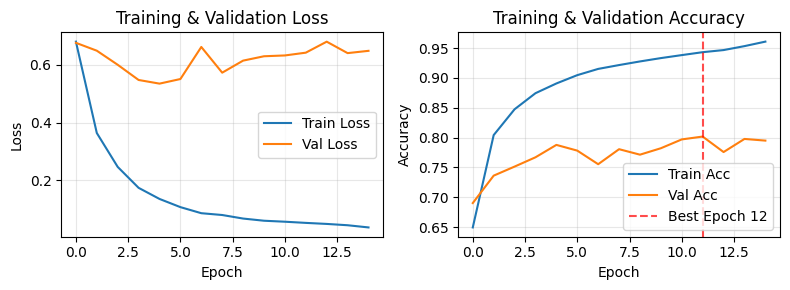

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# loss plot
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy plot
ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, label=f'Best Epoch {best_epoch}')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Compare the embeddings pre and post training to see how finetuning the BERT model has improved the seperation of classes

In [ ]:
post_emb, post_labels = get_embeddings(model, test_loader, device)

165it [00:23,  7.13it/s]


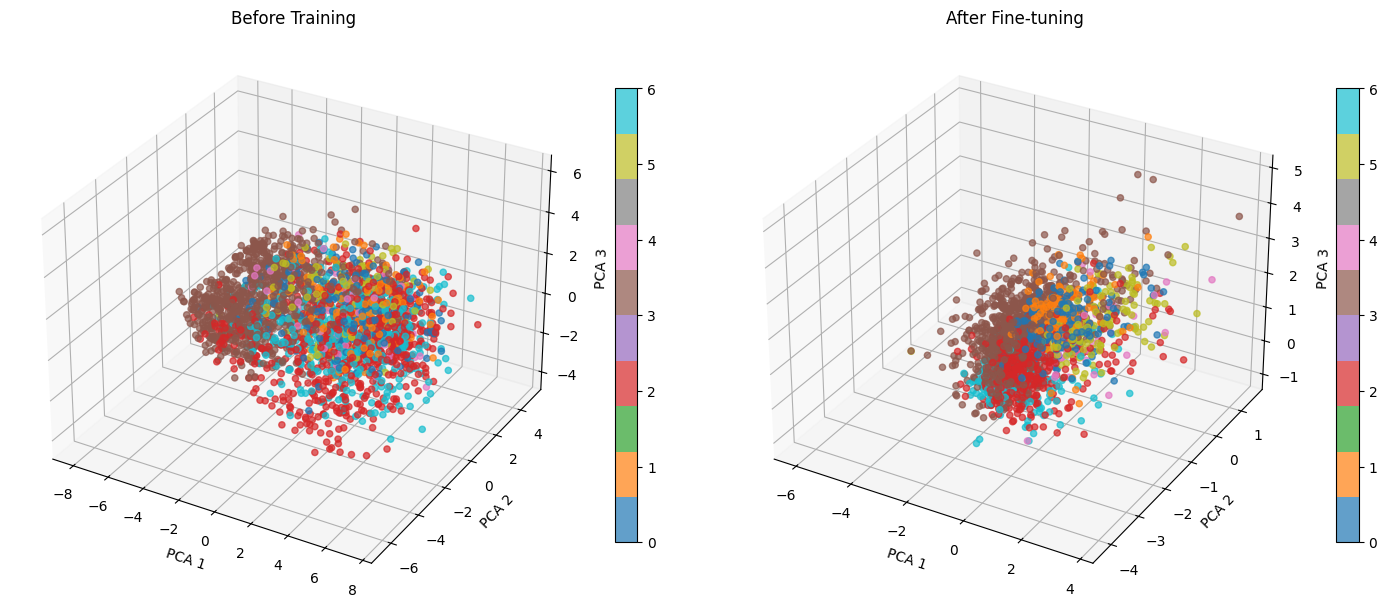

In [ ]:
# PCA to 3D
pca = PCA(n_components=3, random_state=SEED)
pre_3d = pca.fit_transform(pre_emb)
post_3d = pca.transform(post_emb)

fig = plt.figure(figsize=(15, 6))

# pre-training 3D scatter
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(pre_3d[:, 0], pre_3d[:, 1], pre_3d[:, 2], c=pre_labels, cmap='tab10', alpha=0.7)
ax1.set_title('Before Training')
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')

cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.8)

# post-training 3D scatter
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(post_3d[:, 0], post_3d[:, 1], post_3d[:, 2], c=post_labels, cmap='tab10', alpha=0.7)
ax2.set_title('After Fine-tuning')
ax2.set_xlabel('PCA 1')
ax2.set_ylabel('PCA 2')
ax2.set_zlabel('PCA 3')

cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

#Evaluate the Model

Full test evaluation with F1-score, accuracy, and confusion matrix

**Observations:**
* The model correctly predicts `depression` in many cases, but misses a significant number of true `depression` posts, as they are often confused with `suicidal` (which makes sense, due to shared vocabulary and emotional tone)
* The same applies to the `suicidal` class. Model captures most `suicidal` posts, but some are misclassified as `depression`
* `Personality Disorder`, due to being the smallest minority class, shows the lowest precision

In [ ]:
@torch.no_grad()
def test_epoch(model, data_loader, criterion, device, le):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    total = 0

    for batch in tqdm(data_loader, desc="Test"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # metrics
    avg_loss = total_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | Macro-F1: {macro_f1:.4f} | Weighted-F1: {weighted_f1:.4f}")

    # per-class report
    class_names = le.classes_
    print("\nPer-class metrics:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=3))

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'loss': avg_loss, 'accuracy': accuracy,
        'macro_f1': macro_f1, 'weighted_f1': weighted_f1,
        'all_preds': all_preds, 'all_labels': all_labels,
        'cm': cm
    }

Test: 100%|██████████| 165/165 [00:23<00:00,  7.14it/s]


Loss: 0.5883 | Accuracy: 0.8095 | Macro-F1: 0.7946 | Weighted-F1: 0.8127

Per-class metrics:
                      precision    recall  f1-score   support

             Anxiety      0.862     0.875     0.868       192
             Bipolar      0.683     0.928     0.787       139
          Depression      0.806     0.729     0.766       771
              Normal      0.979     0.873     0.923       817
Personality disorder      0.686     0.889     0.774        54
              Stress      0.593     0.915     0.720       129
            Suicidal      0.709     0.741     0.725       533

            accuracy                          0.809      2635
           macro avg      0.760     0.850     0.795      2635
        weighted avg      0.825     0.809     0.813      2635



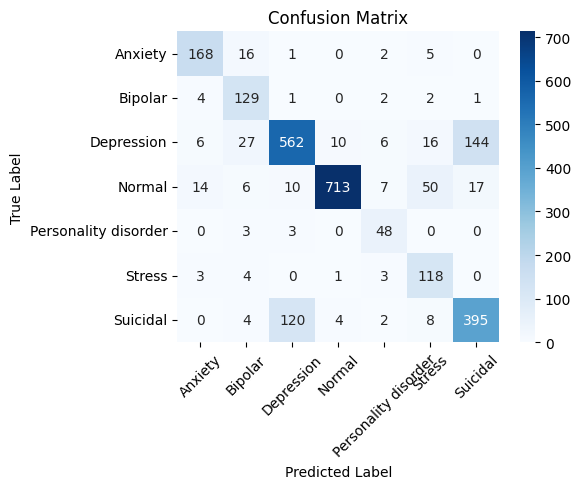

In [ ]:
test_results = test_epoch(model, test_loader, criterion, device, le)

Single-sentence prediction

In [ ]:
def predict_single(model, tokenizer, text, device, le, max_length=512):
    model.eval()
    encoding = tokenizer.encode_plus(
        text, add_special_tokens=True, max_length=max_length,
        return_token_type_ids=False, padding='max_length',
        truncation=True, return_attention_mask=True, return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return le.inverse_transform([pred_class])[0]

In [ ]:
sample = "I am sad. Permanently. I don’t know why."
pred_class = predict_single(model, tokenizer, sample, device, le)
print(f"{pred_class}")

Depression
